# The laws of thermodynamics: applications in models of metabolism

**by Elad Noor**

CompSysBio 2021, Aussois, France

November 15-16, 2021

## 1 Introductions

### 1.1 The laws of thermodynamics

- *0$^\text{th}$ law* - thermodynamic equilibrium is a transitive property
- *1$^\text{st}$ law* - energy is conserved
- *2$^\text{nd}$ law* - the entropy of an isolated system (such as the entire universe) can only increase over time
- *3$^\text{rd}$ law* - a perfect crysal structure at absolute zero will have no entropy

### 1.2 Gibbs free energy (ΔG')

Here, we will calculate the Gibbs free energies of a few reactions and use eQuilibrator for the standard Gibbs energies.

Remember, the formula for the Gibbs free energy is: $$\Delta_r G' = \Delta_r G'^\circ + R T \cdot \ln(Q')$$
where $R$ is the [gas constant](https://en.wikipedia.org/wiki/Gas_constant) and is equal to 8.314e-3 kJ K$^{-1}$ mol$^{-1}$,
$T$ is the temperature in Kelvin,
$Q$ is the reaction quotient and is given by $\prod_i c_i^{\nu_i}$.

Consider the phosphoglucose isomerase (*pgi*) reaction: **D-Glucose 6-phosphate $\rightleftharpoons$ D-Fructose 6-phosphate**

Try searching for it on [eQuilibrator](https://equilibrator.weizmann.ac.il). If you reached the correct page, you should see that
the estimated standard Gibbs free energy ($\Delta_r G'^\circ$) is 2.6 $\pm$ 0.8 (at pH 7.5, pMg 3.0 and ionic strength 0.25M).

Next, we will calculate the $\Delta_r G'$ by setting different values for the concentrations of the two reactants. Notice how we use `Q_` for standard unit quantities (based on the [`pint` package](https://pint.readthedocs.io/)). This ensures that we don't make any mistakes in unit conversion - for example, `pint` automatically translates `R*T` to units of kJ/mol.

In [1]:
import numpy as np
import cvxpy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from equilibrator_api import ComponentContribution, Q_, R, default_T as T
from toggle_cell import toggle_code as hide_sloution

In [2]:
# setting the concentrations of D-Glucose 6-phosphate and D-Fructose 6-phosphate
ni_g6p = -1 # as a substrate, G6P has a stoichiometric coefficient of -1
c_g6p = Q_(1.5, "mM")
ni_f6p = 1 # as a product, F6P has a stoichiometric coefficient of 1
c_f6p = Q_(0.2, "mM")

standard_delta_r_G_prime = Q_(2.6, "kJ/mol")

delta_r_G_prime = standard_delta_r_G_prime + R * T * np.log(c_g6p.m_as("M")**ni_g6p * c_f6p.m_as("M")**ni_f6p)
print(f"ΔG' of pgi = {delta_r_G_prime:.1f}")

ΔG' of pgi = -2.4 kilojoule / mole


So, we can conclude that under these conditions and concentrations, *pgi* is feasible in the forward direction.

<span style="color:blue">
Exercise:

* Try finding this value using the eQuilibrator website itself (by clicking on the icon with blue/green test tubes, you will be able to change the concentrations).
* What would be the direction of *pgi* if the concentration of D-Glucose-6P were 10 times higher? (hint: copy the previous cell and change the value of `c_g6p`)
* What would be the direction of *pgi* if the concentration of D-Fructose-6P were 10 times higher?
* What would be the concentrations of the two reactants at equilibrium, i.e. when ΔrG' = 0? (hint: there is more than one solution, think what is common to all of them)
</span>

Next, we will learn how to use `equilibrator-api` to calculate the Gibbs free energies.

To initialize, run the following cell:

**WARNING** if you are doing this the first time, it might take up to 15 minutes to download the 1.5 GB database.

In [3]:
cc = ComponentContribution()

To estimate a ΔG', we need to create a `Reaction` object by parsing a formula, set the conditions and concentrations, and then use the `dg_prime()` function.
Although text-based search is possible, it is highly recommended to use standard chemical identifiers for the compounds to avoid any mixups.
Here, we will use the BiGG database (which is commonly used for Flux Balance Analysis models)

In [4]:
cc.p_h = Q_(7.5)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")

rxn_pgi = cc.parse_reaction_formula("bigg.metabolite:g6p = bigg.metabolite:f6p")

# one way to calculate ΔG' is using the set_abundance() function
rxn_pgi.set_abundance(cc.get_compound("bigg.metabolite:g6p"), c_g6p)
rxn_pgi.set_abundance(cc.get_compound("bigg.metabolite:f6p"), c_f6p)
print(cc.dg_prime(rxn_pgi))

# another way is to convert ΔG'0 to ΔG' like we did before, using the concentration term
print(cc.standard_dg_prime(rxn_pgi) + R * T * np.log(c_g6p.m_as("M")**ni_g6p * c_f6p.m_as("M")**ni_f6p))

(-2.4 +/- 0.4) kilojoule / mole
(-2.4 +/- 0.4) kilojoule / mole


You can find many more code examples for how to use `equilibrator-api` on the [ReadTheDocs](https://equilibrator.readthedocs.io/en/latest/equilibrator_examples.html) page.

### 1.3 Linear programming (LP)

Here we solve a 2D example LP, using the `CVXPY` package.

Consider the following system:

\begin{eqnarray}
	\textsf{maximize} && x + y \\
	\textsf{subject to} && x + 2y \leq 6 \\
                        && 3x + y \leq 6 \\
                        && x \geq 0, y \geq 0
\end{eqnarray}


In [5]:
x = cvxpy.Variable(shape=1, name="x")
y = cvxpy.Variable(shape=1, name="y")

objective = cvxpy.Maximize(x+y)
constraints = [ x + 2*y <= 6, 3*x + y <= 6, x >= 0, y >= 0 ]
prob = cvxpy.Problem(objective, constraints)
prob.solve()
print(f"x = {x.value[0]:.1f}, y = {y.value[0]:.1f}, objective = {objective.value:.1f}")

x = 1.2, y = 2.4, objective = 3.6


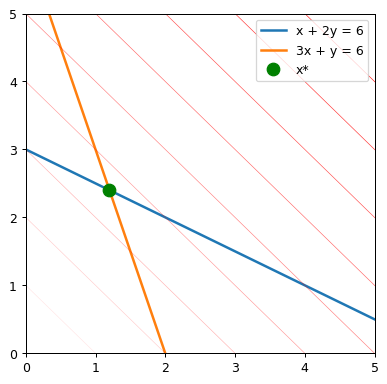

In [6]:
fig = plt.figure(figsize=(5, 5), dpi=90)
ax = fig.add_subplot()

ax.plot([0, 6], [3, 0], '-', label="x + 2y = 6", lw=2)
ax.plot([0, 2], [6, 0], '-', label="3x + y = 6", lw=2)
for i in range(10):
    ax.plot([0, i], [i, 0], 'r', alpha=(i/10.0), lw=0.5)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.plot([x.value[0]], [y.value[0]], "go", label="x*", markersize=10)
ax.legend();

<span style="color:blue">
Exercise:

find the solution to the following LP (using `CVXPY`):

\begin{eqnarray}
    \textsf{minimize} && 6w + 6z \\
    \textsf{subject to} && w + 3z \geq 1 \\
                        && 2w + z \geq 1 \\
                        && w \geq 0, z \geq 0
\end{eqnarray}
</span>

You should get a the same objective value as the first LP (3.6). In fact, the problem you just solved is called the *dual problem* of the original one (called the *primal*). According to the [*strong duality theorem*](https://en.wikipedia.org/wiki/Linear_programming#Duality) they both must have the same solution (assuming they are feasible and bounded). Also, $w$ and $z$ are sometimes called [*shadow prices*](https://en.wikipedia.org/wiki/Shadow_price) and they represent the sensitivity of the solution to each of the inequality constraints of the primal.

In [7]:
hide_sloution()
w = cvxpy.Variable(shape=1, name="w")
z = cvxpy.Variable(shape=1, name="z")
objective = cvxpy.Minimize(6*w + 6*z)
constraints = [ w + 3*z >= 1, 2*w + z >= 1, w >= 0, z >= 0 ]
prob = cvxpy.Problem(objective, constraints)
prob.solve();

### 1.4 Quadratic programming (QP)

Here we solve a 2D example LP, using the `CVXPY` package.

Consider the following system:

\begin{eqnarray}
	\textsf{minimize} && (x-3)^2 + (y-3)^2 \\
	\textsf{subject to} && x + 2y \leq 5 \\
                        && 2x + y \leq 4 \\
                        && x \geq 0, y \geq 0
\end{eqnarray}


In [8]:
x = cvxpy.Variable(shape=1, name="x")
y = cvxpy.Variable(shape=1, name="y")

objective = cvxpy.Minimize((x-3)**2 + (y-2)**2)
constraints = [ x + 2*y <= 6, 3*x + y <= 6, x >= 0, y >= 0 ]
prob = cvxpy.Problem(objective, constraints)
prob.solve()
print(f"x = {x.value[0]:.1f}, y = {y.value[0]:.1f}, objective = {objective.value:.1f}")

x = 1.5, y = 1.5, objective = 2.5


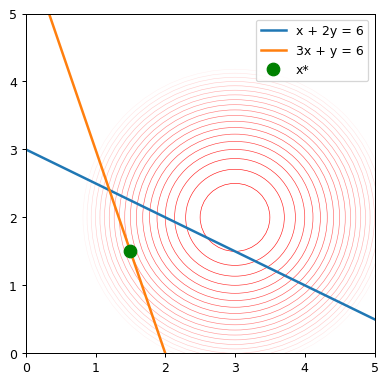

In [9]:
fig = plt.figure(figsize=(5, 5), dpi=90)
ax = fig.add_subplot()

ax.plot([0, 6], [3, 0], '-', label="x + 2y = 6", lw=2)
ax.plot([0, 2], [6, 0], '-', label="3x + y = 6", lw=2)
for i in range(20):
    ellipse = Ellipse(xy=(3, 2), width=np.sqrt(i), height=np.sqrt(i), lw=0.5, edgecolor='r', fc='None', alpha=((20-i)/20.0))
    ax.add_patch(ellipse)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.plot([x.value[0]], [y.value[0]], "go", label="x*", markersize=10)
ax.legend();

### 1.5 Mixed-Integer Linear Programming (MILP)

Here we use the same LP as in 1.3, but we add the constraint that $x$ and $y$ must be integers.

In [10]:
x = cvxpy.Variable(shape=1, name="x", integer=True)
y = cvxpy.Variable(shape=1, name="y", integer=True)

objective = cvxpy.Maximize(x+y)
constraints = [ x + 2*y <= 6, 3*x + y <= 6, x >= 0, y >= 0 ]
prob = cvxpy.Problem(objective, constraints)
prob.solve()
print(f"x = {x.value[0]:.1f}, y = {y.value[0]:.1f}, objective = {objective.value:.1f}\n")

x = 1.0, y = 2.0, objective = 3.0

Long-step dual simplex will be used


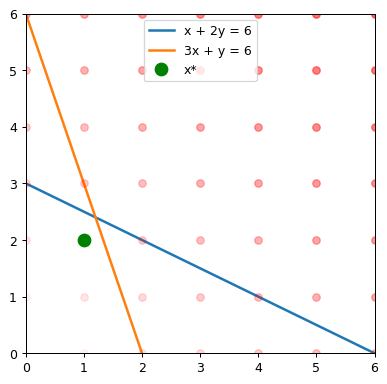

In [11]:
fig = plt.figure(figsize=(5, 5), dpi=90)
ax = fig.add_subplot()

ax.plot([0, 6], [3, 0], '-', label="x + 2y = 6", lw=2)
ax.plot([0, 2], [6, 0], '-', label="3x + y = 6", lw=2)
for i in range(7):
    for j in range(7):
        ax.plot(i, j, 'ro', alpha=(i+j)/20.0)
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)
ax.plot([x.value[0]], [y.value[0]], "go", label="x*", markersize=10)
ax.legend();

As you can see, the MILP solution is different since the LP optimum does not have integer values. Although they look simpler, MILP problems are notoriously difficult to solve and are not scalable to a very large number of variables.

## 2 Flux Balance Analysis

Flux Balance Analysis (FBA) is an umbrella term for constraint-based methods (usually Linear or Quadratic Programming) that focus on the structure metabolic network. This network is typically represented as a stoichiometric matrix, where metabolites are rows and reactions are columns.

The main assumption that FBA makes is called pseudo steady-state, which means that all internal metabolite pools are constant over time. If $\mathbf{S}$ is the stoichiometric matrix and $\boldsymbol{v}$ is the flux vector, the pseudo steady-state translates to the following constraint: $$\mathbf{S} \boldsymbol{v} = 0$$

In addition, the rate of each reaction in the model is constrained by an upper and lower bound. Some reactions are irreversible and therefore have a lower bound of 0: $$\boldsymbol{v^{lb}} \leq \boldsymbol{v} \leq \boldsymbol{v^{ub}}$$

The last thing we need for an FBA model is an objective function. The most common objective to use is the biomass function, a reaction that converts a fixed-stoichiometry collection of biomass precursors into biomass. As an example, take a look at the [biomass objective function for the E. coli core model](http://bigg.ucsd.edu/models/e_coli_core/reactions/BIOMASS_Ecoli_core_w_GAM). This reaction does not represent a single enzymatic step like most other reactions, but rather is a lumping of many processes into a single step (including tRNA loading, transcription, translation, DNA replication, membrane formation, etc.). In the Linear Programming framework, we set this biomass reaction as the objective (by setting its coefficient in the $\boldsymbol{c}$ vector to 1, and all others to 0). Therefore $\boldsymbol{c}^\top \boldsymbol{v} = v_{BM}$.


In summary, FBA is performed by solvering the following LP:

\begin{align}
&\text{maximize}     &v_{BM}\\
&\text{with}         &\mathbf{S}\boldsymbol{v} = 0\\
&\text{and}          &\boldsymbol{v^{lb}} \leq \boldsymbol{v} \leq \boldsymbol{v^{ub}}
\end{align}


In the following exercise, we will find the FBA solution for the E. coli core model, using the [`COBRApy` package](https://cobrapy.readthedocs.io).

In [12]:
import numpy as np
import cobra
import cobra.test
import escher as es

In [13]:
# Load the Core Model and explore it by inspecting the model parameters.
model = cobra.test.create_test_model("textbook")

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


The model contains different fields for which a brief description is provided below:

|object |description |
|---|----|
| reactions | all reactions of the model |
|meatbolites| all present metabolites|
|genes| genes/enzymes that catalize the reactions|
|compartments| the diffrent compartments of the cell|

In [14]:
S = cobra.util.create_stoichiometric_matrix(model)
Nc, Nr = S.shape

v = cvxpy.Variable(shape=Nr, name="flux")
v_lb, v_ub = zip(*[r.bounds for r in model.reactions])
c = np.zeros(Nr)

biomass_reaction = model.reactions.get_by_id("Biomass_Ecoli_core")
display(biomass_reaction)
c[model.reactions.index(biomass_reaction)] = 1.0

<Reaction Biomass_Ecoli_core at 0x7febd09bff40>

In [15]:
objective = cvxpy.Maximize(c @ v)
constraints = [ S @ v == 0, v_lb <= v, v <= v_ub ]
prob = cvxpy.Problem(objective, constraints)
prob.solve()

# we store the flux solution in a dictionary in order to display it later
solution = dict(zip([r.id for r in model.reactions], v.value))
print(f"Maximal biomass rate = {solution[biomass_reaction.id]:.1f}")

Maximal biomass rate = 0.9


Now, we use [Escher](https://escher.readthedocs.io/) to visualize our solution on a metabolic map

In [16]:
network_map_solution = es.Builder(map_name='e_coli_core.Core metabolism', model=model, reaction_data=solution)
display(network_map_solution)

Builder(reaction_data={'ACALD': -3.2342014981006196e-10, 'ACALDt': -1.6986758696600056e-10, 'ACKr': -2.5611498…

One thing that pops up is the high flux in the internal cycle consisting of succinate dehydrogenase (SUCDi) and fumarate reductase (FRD7). Because it does not affect the objective function, the solver can add any value to both fluxes and it will cancel out. One way to prevent internal cycles is to add a secondary objective, which minimizes $||\boldsymbol{v}||_2$ - i.e. the sum of all squared fluxes. We do this by adding the `norm2` of the flux vector times a small negative scalar (-1e-5) to the standard objective.


In [17]:
objective = cvxpy.Maximize(c @ v - 1e-5 * cvxpy.norm2(v))
prob = cvxpy.Problem(objective, constraints)
prob.solve()

# we store the flux solution in a dictionary in order to display it later
solution = dict(zip([r.id for r in model.reactions], v.value))
print(f"Maximal biomass rate = {solution[biomass_reaction.id]:.1f}")

Maximal biomass rate = 0.9


In [18]:
network_map_solution = es.Builder(map_name='e_coli_core.Core metabolism', model=model, reaction_data=solution)
display(network_map_solution)

Builder(reaction_data={'ACALD': -3.9660373352900553e-11, 'ACALDt': -2.1197031104526653e-11, 'ACKr': -3.1815865…

Check to see what happened to the SUCDi/FRD7 internal cycle. 

<span style="color:blue">
Exercise:

Change the bounds of the fumarase reaction (FUM) to 0, so that no flux can go through it.
Solve the FBA problem again and plot the results using Escher.
    
What is the new maximal biomass rate? Why do you think it has changed?
</span>

In [19]:
hide_sloution()
model.reactions.FUM.bounds = (0.0, 0.0)
v_lb, v_ub = zip(*[r.bounds for r in model.reactions])

objective = cvxpy.Maximize(c @ v - 1e-5 * cvxpy.norm2(v))
constraints = [ S @ v == 0, v_lb <= v, v <= v_ub ]
prob = cvxpy.Problem(objective, constraints)
prob.solve()

# we store the flux solution in a dictionary in order to display it later
solution = dict(zip([r.id for r in model.reactions], v.value))

## 3 Thermodynamics in constraint-based models

### 3.1 Max-min Driving Force

We start with a toy model comprising 3 reactions:
* succinate dehydrogenase (sdh): succinate + ubiquinone -> fumarate + ubiquinol
* fumarase (fum): fumarate + H2O -> malate
* malate dehydrogenase (mdh): malate + NAD$^+$ -> oxaloacetate + NADH
* citrate synthase (cs): oxaloacetate + acetyl-CoA + H2O -> citrate + CoA

Will will be using `equilibrator-api` to obtain the standard reaction energies (in case you skipped it, see exercise 1.2 to learn more about the package).

In [20]:
import numpy as np
import cvxpy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from equilibrator_api import ComponentContribution, Q_, ureg, R, default_T as T
from scipy import stats

In [21]:
cc = ComponentContribution()

In [22]:
rxn_sdh = cc.parse_reaction_formula("bigg.metabolite:succ + bigg.metabolite:q8 = bigg.metabolite:fum + bigg.metabolite:q8h2")
rxn_fum = cc.parse_reaction_formula("bigg.metabolite:fum + bigg.metabolite:h2o = bigg.metabolite:mal__L")
rxn_mdh = cc.parse_reaction_formula("bigg.metabolite:mal__L + bigg.metabolite:nad = bigg.metabolite:oaa + bigg.metabolite:nadh")
rxn_cs = cc.parse_reaction_formula("bigg.metabolite:oaa + bigg.metabolite:accoa + bigg.metabolite:h2o = bigg.metabolite:cit + bigg.metabolite:coa")
reactions = [rxn_sdh, rxn_fum, rxn_mdh, rxn_cs]
for i, rxn in enumerate(reactions):
    assert rxn.is_balanced(), f"Reaction {i} is not balanced: {rxn}" + str(rxn.get_element_data_frame())

In [23]:
cc.p_h = Q_(7.5)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
RT = R * T
standard_dg_primes, _ = cc.standard_dg_prime_multi(reactions, uncertainty_representation="fullrank")
display("mean(ΔG'0) = ", standard_dg_primes.round(1))

"mean(ΔG'0) = "

array([-73.6,  -3.4,  26.5, -38.8]) <Unit('kilojoule / mole')>

In [24]:
# collect model parameters
S = cc.create_stoichiometric_matrix(reactions).values
Nc, Nr = S.shape
c_lbs = np.ones(Nc) * np.log(1e-6)  # we set all lower bounds to 0.1 mM
c_ubs = np.ones(Nc) * np.log(1e-3)  # we set all upper bounds to 10 mM

# set up the model variables and their relationships
ln_conc = cvxpy.Variable(shape=Nc, name="log concentrations")
dg_prime_over_rt = (standard_dg_primes / RT).m_as("") + S.T @ ln_conc
B = cvxpy.Variable(shape=1, name="minimal driving force (in units of RT)")

# create the LP using CVXPY
objective = cvxpy.Maximize(B)
constraints = [
    c_lbs <= ln_conc, ln_conc <= c_ubs, # concentrations
    dg_prime_over_rt <= -B, # driving forces
]
prob = cvxpy.Problem(objective, constraints)

# solve using CVXPY and display the Max-min Driving Force solution
prob.solve()
print(f"MDF = {prob.value * RT:.1f}")

MDF = -3.0 kilojoule / mole


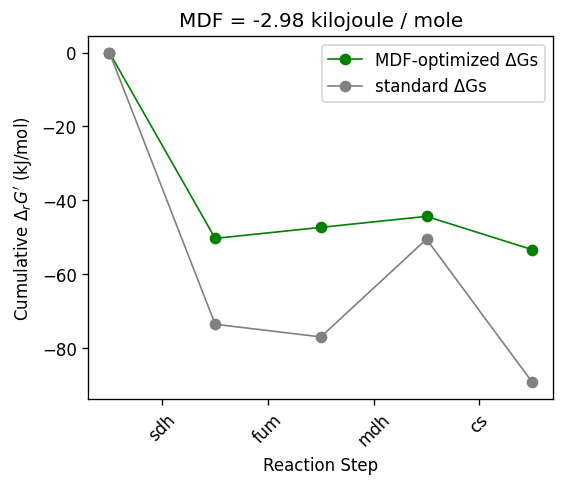

In [25]:
ureg.setup_matplotlib(True)  # setup matplotlib so that we will be able to use arrays with units as inputs

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=120)

standard_dgs = np.array([0.0] + (standard_dg_primes / RT).m_as("").tolist(), dtype=float, ndmin=1) * RT
optimal_dgs = np.array([0.0] + dg_prime_over_rt.value.tolist(), dtype=float, ndmin=1) * RT

ax.plot(optimal_dgs.cumsum(), "-o", label="MDF-optimized ΔGs", color="green", linewidth=1)
ax.plot(standard_dgs.cumsum(), "-o", label="standard ΔGs", color="grey", linewidth=1)

ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels(["sdh", "fum", "mdh", "cs"], rotation=45, ha="center")
ax.set_xlabel("Reaction Step")
ax.set_ylabel(r"Cumulative $\Delta_r G^\prime$ (kJ/mol)")
ax.legend(loc="best")
ax.set_title(f"MDF = {prob.value * RT:.2f}");

This result tells us that the pathway is not feasible in the given conditions (pH, I, concentration bounds). In reality, it is likely that some of the metabolites in this pathway are either lower than 1μM or higher than 1mM.

<span style="color:blue">
Exercise:

Check what happened to the MDF value if the concentration upper bound was 10 mM instead of 1 mM (i.e. the range would be 1 μM - 10 mM). Would it be feasible then?

</span>

In [26]:
hide_sloution()

# collect model parameters
S = cc.create_stoichiometric_matrix(reactions).values
Nc, Nr = S.shape
c_lbs = np.ones(Nc) * np.log(1e-6)  # we set all lower bounds to 0.1 mM
c_ubs = np.ones(Nc) * np.log(1e-2)  # we set all upper bounds to 10 mM

# set up the model variables and their relationships
ln_conc = cvxpy.Variable(shape=Nc, name="log concentrations")
dg_prime_over_rt = (standard_dg_primes / RT).m_as("") + S.T @ ln_conc
B = cvxpy.Variable(shape=1, name="minimal driving force (in units of RT)")

# create the LP using CVXPY
objective = cvxpy.Maximize(B)
constraints = [
    c_lbs <= ln_conc, ln_conc <= c_ubs, # concentrations
    dg_prime_over_rt <= -B, # driving forces
]
prob = cvxpy.Problem(objective, constraints)

# solve using CVXPY and display the Max-min Driving Force solution
prob.solve();

**Advanced**: When solving MDF, we can also take the uncertainty in the component-contribution estimates into account. 

In [27]:
standard_dg_primes, dg_sigma = cc.standard_dg_prime_multi(reactions, uncertainty_representation="fullrank")
display("covariance(ΔG'0) = ", (dg_sigma @ dg_sigma.T).round(1))

"covariance(ΔG'0) = "

array([[42.5, -0.1, -0. , -0. ],
       [-0.1,  0.1, -0. ,  0. ],
       [-0. , -0. ,  0.1, -0. ],
       [-0. ,  0. , -0. ,  0.2]]) <Unit('kilojoule ** 2 / mole ** 2')>

In [28]:
# set the desired level of confidence
dg_confidence = 0.95

# set up the constraints on the probability distribution of ΔG'0 using the chosen confidence level
Nq = dg_sigma.shape[1]
y = cvxpy.Variable(shape=Nq, name="covariance eigenvalues")
dg_prime_over_rt = (standard_dg_primes / RT).m_as("") + S.T @ ln_conc + (dg_sigma / RT).m_as("") @ y

# set the objective and create the LP using CVXPY
objective = cvxpy.Maximize(B)
constraints = [
    c_lbs <= ln_conc, ln_conc <= c_ubs, # concentrations
    dg_prime_over_rt <= -B, # driving forces
    cvxpy.norm2(y) <= stats.chi2.ppf(dg_confidence, Nq) ** (0.5) # probability confidence
]
prob = cvxpy.Problem(objective, constraints)

# solve using CVXPY and display the Max-min Driving Force solution
prob.solve()
print(f"MDF = {prob.value * RT:.1f}")

MDF = 6.2 kilojoule / mole


as we can see, accounting for uncertainty increases the MDF, because the optimization can assign lower ΔG'0 values than the mean.

## 3.2 Thermodynamic Flux Balance Analysis

In [1]:
# we repeat the same initial steps as in the standard FBA (exercise 2)
import numpy as np
import cobra
import cobra.test
import escher as es
import cvxpy
model = cobra.test.create_test_model("textbook")
S = cobra.util.create_stoichiometric_matrix(model)
Nc, Nr = S.shape
v = cvxpy.Variable(shape=Nr, name="flux")
v_lb, v_ub = zip(*[r.bounds for r in model.reactions])
c = np.zeros(Nr)
biomass_reaction = model.reactions.get_by_id("Biomass_Ecoli_core")
c[model.reactions.index(biomass_reaction)] = 1.0
objective = cvxpy.Maximize(c @ v)
constraints = [ S @ v == 0, v_lb <= v, v <= v_ub ]

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [2]:
prob = cvxpy.Problem(objective, constraints)
prob.solve(solver="GUROBI")
print(prob.status)
print(f"FBA solution = {prob.value:.3f}")

SolverError: The solver GUROBI is not installed.

TypeError: 'module' object is not callable

In [31]:
# now we add the extra thermodynamic constraints
c_lbs = np.ones(Nc) * np.log(1e-20)  # we set all lower bounds to 1 μM
c_ubs = np.ones(Nc) * np.log(1e+20)  # we set all upper bounds to 10 mM
ln_conc = cvxpy.Variable(shape=Nc, name="log concentrations")
constraints += [c_lbs <= ln_conc, ln_conc <= c_ubs]


M = 1e3
epsilon = 1e-3
standard_dg_primes = Q_(np.zeros(Nr), "kJ/mol")
dg_prime_over_rt = (standard_dg_primes / RT).m_as("") + S.T @ ln_conc
indicators = cvxpy.Variable(Nr, integer=True)
constraints += [
    0 <= indicators, indicators <= 1,
    0 <= M*indicators - v, M*indicators - v <= M,
    epsilon <= M*indicators - dg_prime_over_rt,
    M*indicators - dg_prime_over_rt <= M - epsilon,
]


In [ ]:
prob = cvxpy.Problem(objective, constraints)
prob.solve()
print(prob.status)
print(f"FBA solution = {prob.value:.3f}")